In [1]:
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
'''def data_from_matlab(matlab: str):
    data = loadmat(matlab)
    gt = data['gainTime']
    gws = data['gainWinSoln']'''

"def data_from_matlab(matlab: str):\n    data = loadmat(matlab)\n    gt = data['gainTime']\n    gws = data['gainWinSoln']"

In [3]:
'''def utc_midpts(data: list):
    utc_midpts = []
    for t in range(len(gt)):
        midpt = 0.5 * (gt[t][0].real + gt[t][0].imag)
        utc_midpts.append((midpt%1)*24)'''

'def utc_midpts(data: list):\n    utc_midpts = []\n    for t in range(len(gt)):\n        midpt = 0.5 * (gt[t][0].real + gt[t][0].imag)\n        utc_midpts.append((midpt%1)*24)'

In [4]:
'''def gain_win_soln(data: dict):

    n_times = len(gws)
    n_ants = len(gws[0])
    n_spws = len(gws[0][0])

    colors = ['blue','orange','y','purple','r','g','m','c']

    n_rows = math.ceil(n_ants / 2)
    n_cols = 2

    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(8,6))
    fig2, ax2 = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(8.5,7))

    max_amp = 0

    for spw in range(n_spws):
        for ant in range(n_ants):
            amp_to_plot, pha_to_plot = [], []

            if ant < n_rows:
                    row, col = ant, 0
            else:
                row, col = ant % n_rows, 1

            for time in range(n_times):
                amp_val = abs((gws.copy())[time][ant][spw])
                pha_val = np.angle((gws.copy())[time][ant][spw], deg=True)
                amp_to_plot.append(amp_val)
                pha_to_plot.append(pha_val)

                if amp_val > max_amp:
                    max_amp = amp_val

                ax[row, col].scatter([utc_midpts[time]], amp_to_plot, c=colors[spw], s=4)
                ax2[row, col].scatter([utc_midpts[time]], pha_to_plot, c=colors[spw], s=4)

                ax[row, col].yaxis.set_label_position('right')
                ax2[row, col].yaxis.set_label_position('right')
                ax[row, col].set_ylabel(f'Ant{ant}')
                ax2[row, col].set_ylabel(f'Ant{ant}')
                amp_to_plot, pha_to_plot = [], []

    plt.setp(ax, xticks=np.arange((min(utc_midpts)//1), (max(utc_midpts)//1)+2, 1), yticks=np.arange(0, max_amp+1, 0.5))
    plt.setp(ax2, xticks=np.arange((min(utc_midpts)//1), (max(utc_midpts)//1)+2, 1), yticks=[-180,-120,-60,0,60,120,180])
    fig.suptitle('Gain solutions for amplitude')
    fig2.suptitle('Gain solutions for phase')
    fig.supxlabel('UT hours')
    fig2.supxlabel('UT hours')
    fig.supylabel('Gain amplitude')
    fig2.supylabel('Gain phase')

    plt.show()'''

"def gain_win_soln(data: dict):\n\n    n_times = len(gws)\n    n_ants = len(gws[0])\n    n_spws = len(gws[0][0])\n\n    colors = ['blue','orange','y','purple','r','g','m','c']\n\n    n_rows = math.ceil(n_ants / 2)\n    n_cols = 2\n\n    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(8,6))\n    fig2, ax2 = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(8.5,7))\n\n    max_amp = 0\n\n    for spw in range(n_spws):\n        for ant in range(n_ants):\n            amp_to_plot, pha_to_plot = [], []\n\n            if ant < n_rows:\n                    row, col = ant, 0\n            else:\n                row, col = ant % n_rows, 1\n\n            for time in range(n_times):\n                amp_val = abs((gws.copy())[time][ant][spw])\n                pha_val = np.angle((gws.copy())[time][ant][spw], deg=True)\n                amp_to_plot.append(amp_val)\n                pha_to_plot.append(pha_val)\n\n                if amp_val > max_amp:\n                

In [5]:
data = loadmat('../data/250611_03:56:34/gains.mat')

In [6]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Jun 11 03:17:17 2025',
 '__version__': '1.0',
 '__globals__': [],
 'gainAntSoln': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
 'gainWinSoln': array([[[ 1.        +0.j        ,  1.        +0.j        ,
           1.        +0.j        ,  1.        +0.j        ],
         [ 1.        +0.j        ,  1.        +0.j        ,
           1.        +0.j        ,  1.        +0.j        ],
         [ 1.        +0.j        ,  1.        +0.j        ,
           1.        +0.j        ,  1.        +0.j        ],
         ...,
         [ 1.        +0.j        ,  1.        +0.j        ,
           1.        +0.j        ,  1.        +0.j        ],
         [ 1.        +0.j        ,  1.        +0.j        ,
           1.        +0.j        ,  1.        +

In [7]:
for key in data:
    print(key)

__header__
__version__
__globals__
gainAntSoln
gainWinSoln
gainChanSoln
gainDelaySoln
gainSou
gainTime
gainType
gainRefAnt
noiseSpec
noiseCorr
apEffCorr
gainPrefs
hostName
timeStamp


In [8]:
gain_type = data['gainType']

In [9]:
gain_type

array([[45],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [30],
       [78],
       [78],
       [78],

In [25]:
gain_type & (2**7)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [11]:
gt = data['gainTime']

In [12]:
gws = data['gainWinSoln']

In [13]:
gcs = data['gainChanSoln']

In [14]:
gcs[0][0]

array([[1.06802815+0.j, 1.06117571+0.j, 1.0096956 +0.j, 0.99035021+0.j,
        0.96389957+0.j, 0.9342948 +0.j],
       [1.09324298+0.j, 1.0782071 +0.j, 1.0205493 +0.j, 0.97924597+0.j,
        0.94272549+0.j, 0.90412666+0.j],
       [1.06684128+0.j, 1.07958506+0.j, 1.00065391+0.j, 0.99931085+0.j,
        0.96978904+0.j, 0.97102483+0.j],
       [1.04499331+0.j, 1.0564321 +0.j, 0.97627685+0.j, 1.01248771+0.j,
        1.00382339+0.j, 0.96470398+0.j]])

In [15]:
n_times = len(gt)
n_ants = len(gws[0])
n_spws = len(gws[0][0])

In [16]:
n_chans = len(gcs[0][0][0])

In [17]:
colors = ['blue','orange','y','purple','r','g','m','c']

In [18]:
utc_midpts = []
for t in range(len(gt)):
    midpt = 0.5 * (gt[t][0].real + gt[t][0].imag)
    utc_midpts.append((midpt%1)*24)

In [19]:
gcs[0][0][0]

array([1.06802815+0.j, 1.06117571+0.j, 1.0096956 +0.j, 0.99035021+0.j,
       0.96389957+0.j, 0.9342948 +0.j])

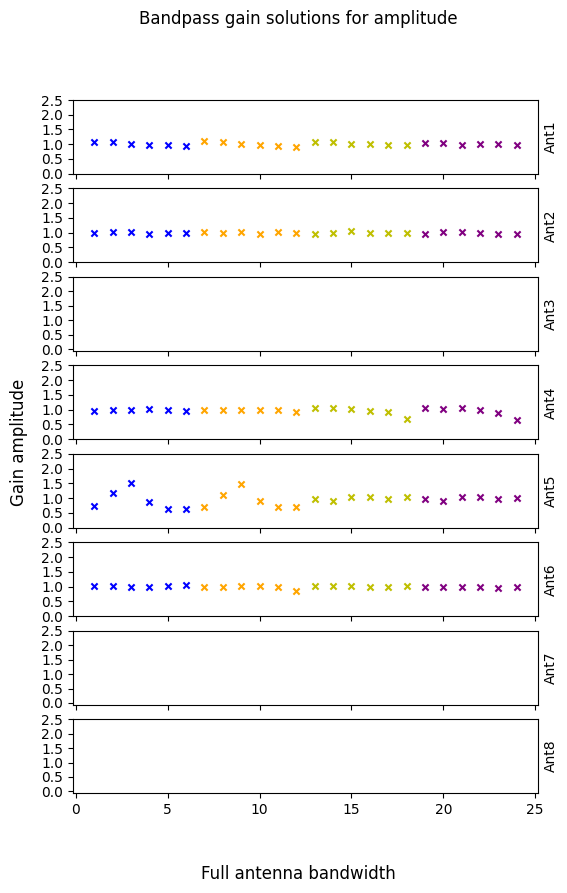

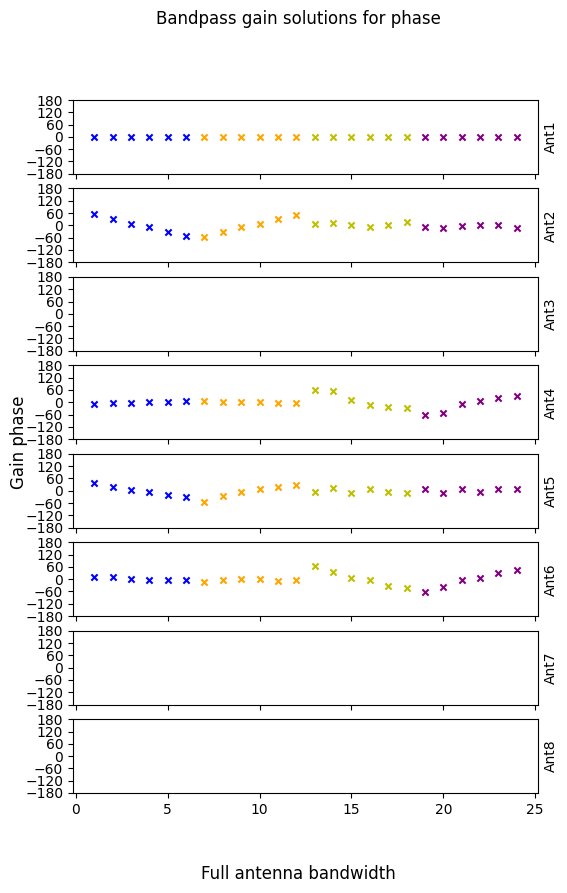

In [ ]:
########## gain chan soln ##########

fig, ax = plt.subplots(nrows=n_ants, ncols=1, sharex=True, figsize=(4,12))
fig2, ax2 = plt.subplots(nrows=n_ants, ncols=1, sharex=True, figsize=(4,12))

max_amp = 0

for time in range(n_times):
    if (gain_type & (2**0))[time] != 0:
        for ant in range(n_ants):
            for spw in range(n_spws):
                amp_to_plot = [abs(a) for a in gcs.copy()[time][ant][spw]]
                pha_to_plot = [np.angle(p, deg=True) for p in gcs.copy()[time][ant][spw]]
                if max(amp_to_plot) > max_amp:
                    max_amp = max(amp_to_plot)

                x_axis = np.arange(spw * n_chans + 1, (1 + spw) * n_chans + 1)

                ax[ant].scatter(x_axis, amp_to_plot, c=colors[spw], s=20, marker='x')
                ax2[ant].scatter(x_axis, pha_to_plot, c=colors[spw], s=20, marker='x')

                ax[ant].yaxis.set_label_position('right')
                ax2[ant].yaxis.set_label_position('right')
                ax[ant].set_ylabel(f'Ant{ant+1}')
                ax2[ant].set_ylabel(f'Ant{ant+1}')

plt.setp(ax, yticks=np.arange(0, max_amp+1, 0.5))
plt.setp(ax2, yticks=[-180,-120,-60,0,60,120,180])
fig.suptitle('Bandpass gain solutions for amplitude')
fig2.suptitle('Bandpass gain solutions for phase')
fig.supxlabel('Full antenna bandwidth')
fig2.supxlabel('Full antenna bandwidth')
fig.supylabel('Gain amplitude')
fig2.supylabel('Gain phase')

plt.show()

In [21]:
n_rows = math.ceil(n_ants / 2)
n_cols = 2

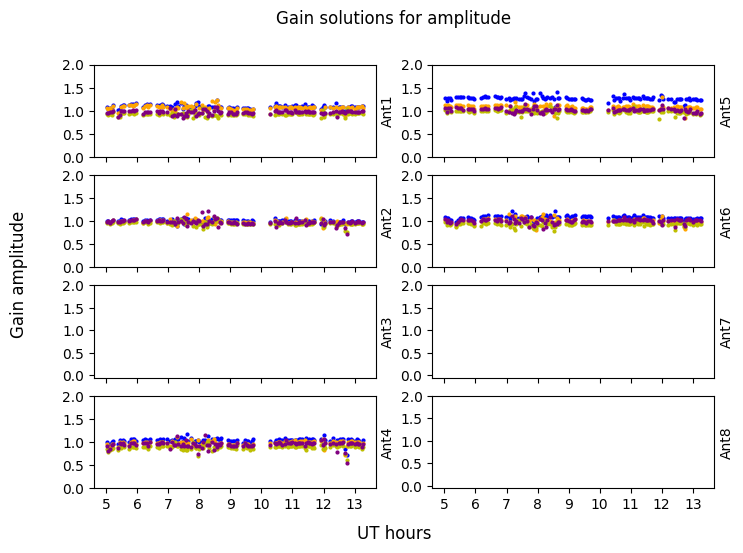

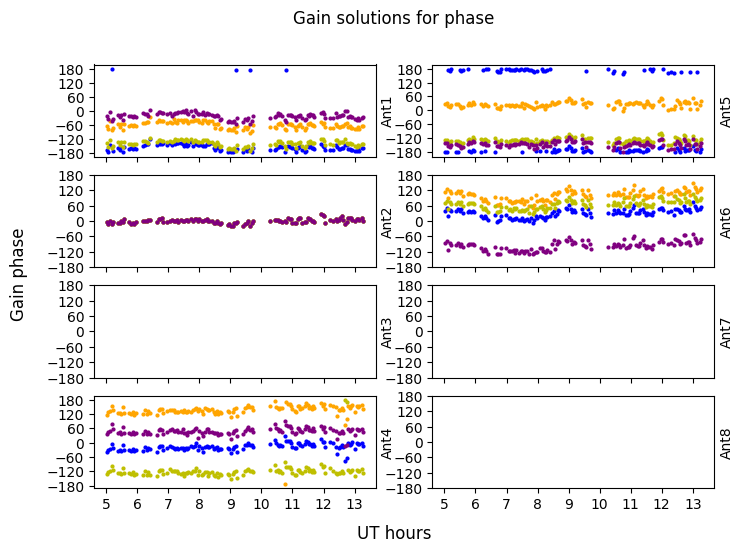

In [22]:
########## gain win soln ##########

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(8,5.5))
fig2, ax2 = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(8,5.5))

max_amp, min_time, max_time = 0, float('inf'), 0

for spw in range(n_spws):
    for ant in range(n_ants):
        amp_to_plot, pha_to_plot = [], []

        if ant < n_rows:
                row, col = ant, 0
        else:
            row, col = ant % n_rows, 1

        for time in range(n_times):
            if gain_type[time] & (2**6) != 0:
                amp_val = abs((gws.copy())[time][ant][spw])
                pha_val = np.angle((gws.copy())[time][ant][spw], deg=True)
                amp_to_plot.append(amp_val)
                pha_to_plot.append(pha_val)

                if amp_val > max_amp:
                    max_amp = amp_val

                t = utc_midpts[time]
                if t < min_time:
                    min_time = t
                if t > max_time:
                    max_time = t

                ax[row, col].scatter([t], amp_to_plot, c=colors[spw], s=4)
                ax2[row, col].scatter([t], pha_to_plot, c=colors[spw], s=4)

                ax[row, col].yaxis.set_label_position('right')
                ax2[row, col].yaxis.set_label_position('right')
                ax[row, col].set_ylabel(f'Ant{ant+1}')
                ax2[row, col].set_ylabel(f'Ant{ant+1}')
                amp_to_plot, pha_to_plot = [], []

plt.setp(ax, xticks=np.arange(min_time//1, math.ceil(max_time), 1), yticks=np.arange(0, max_amp+1, 0.5))
plt.setp(ax2, xticks=np.arange(min_time//1, math.ceil(max_time), 1), yticks=[-180,-120,-60,0,60,120,180])
fig.suptitle('Gain solutions for amplitude')
fig2.suptitle('Gain solutions for phase')
fig.supxlabel('UT hours')
fig2.supxlabel('UT hours')
fig.supylabel('Gain amplitude')
fig2.supylabel('Gain phase')

plt.show()